# Part A 

In [15]:
# IMPORT LIBRARIES
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from langdetect import detect
from IPython.display import display
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.options.display.float_format = '{:.2f}'.format

plt.style.use('petroff10')
sns.set_palette("husl")


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/macbookair/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:

# LOAD AND PREPARE DATASET
df = pd.read_csv('datasets/sms_spam_train.csv')
df['Label'] = df['Label'].map({'spam': 1, 'ham': 0})
print("Dataset Shape:", df.shape)
display(df.head())

Dataset Shape: (10000, 2)


,Message,Label
0,Whats upp ac enisteee: -) senin memlekette bul...,0
1,"Kampanya, VakifBank Worldcardla 31 Mayisa kada...",1
2,I wont. So wat's wit the guys,0
3,Bu arada son dakika evi düşürdük,0
4,No that just means you have a fat head,0


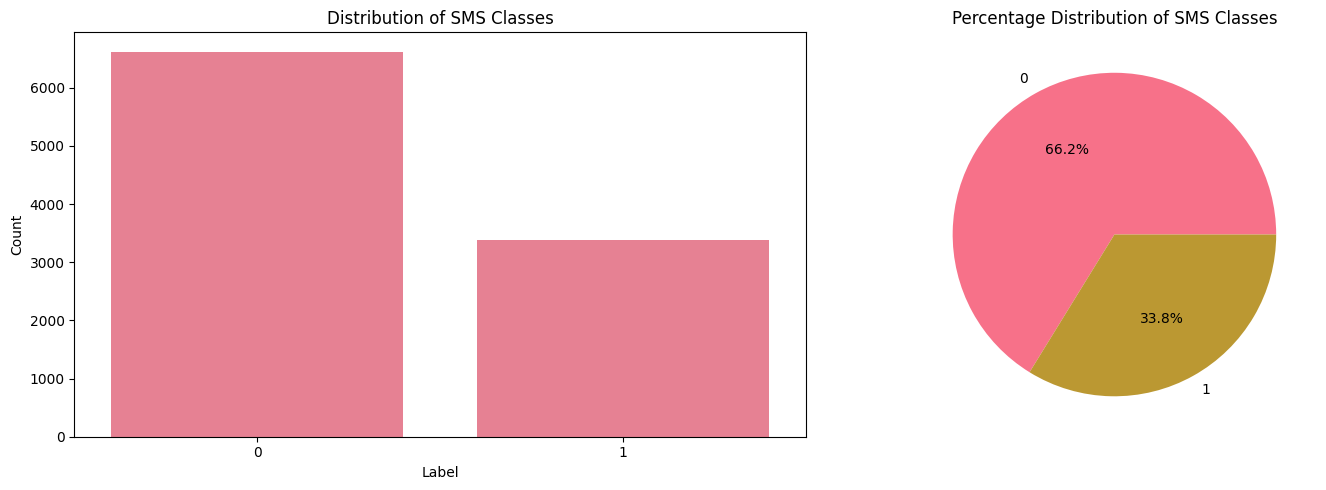

In [3]:
# VISUALIZE CLASS DISTRIBUTION AND BALANCE
class_dist = df['Label'].value_counts()
class_dist_pct = df['Label'].value_counts(normalize=True) * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
sns.barplot(x=class_dist.index, y=class_dist.values, ax=ax1)
ax1.set_title('Distribution of SMS Classes')
ax1.set_ylabel('Count')

ax2.pie(class_dist_pct, labels=class_dist.index, autopct='%1.1f%%')
ax2.set_title('Percentage Distribution of SMS Classes')
plt.tight_layout()
plt.show()

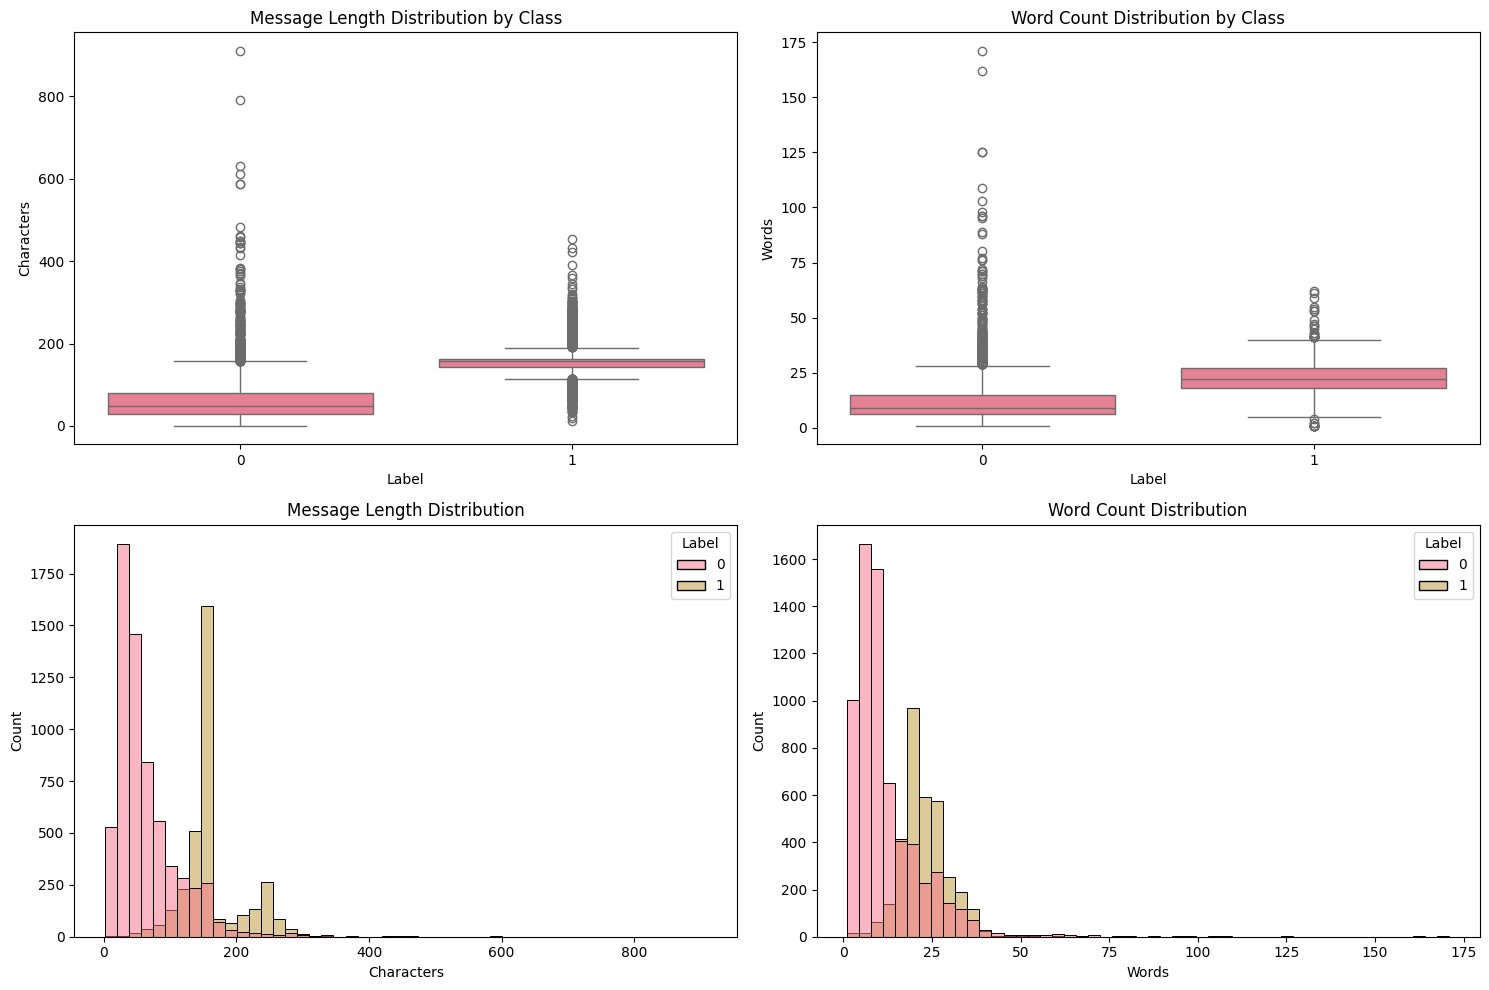


Message Length Statistics:


msg_length                                                word_count                                          
           count   mean   std   min    25%    50%    75%    max      count  mean   std  min   25%   50%   75%    max
Label                                                                                                               
0        6621.00  64.04 53.77  1.00  30.00  48.00  81.00 910.00    6621.00 12.04 10.40 1.00  6.00  9.00 15.00 171.00
1        3379.00 164.53 46.61 13.00 143.00 157.00 162.00 453.00    3379.00 22.71  6.56 1.00 18.00 22.00 27.00  62.00

In [4]:
# ANALYZE MESSAGE LENGTH CHARACTERISTICS
df['msg_length'] = df['Message'].str.len()
df['word_count'] = df['Message'].str.split().str.len()

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
sns.boxplot(x='Label', y='msg_length', data=df, ax=axes[0,0])
axes[0,0].set_title('Message Length Distribution by Class')
axes[0,0].set_ylabel('Characters')

sns.boxplot(x='Label', y='word_count', data=df, ax=axes[0,1])
axes[0,1].set_title('Word Count Distribution by Class')
axes[0,1].set_ylabel('Words')

sns.histplot(data=df, x='msg_length', hue='Label', bins=50, ax=axes[1,0])
axes[1,0].set_title('Message Length Distribution')
axes[1,0].set_xlabel('Characters')

sns.histplot(data=df, x='word_count', hue='Label', bins=50, ax=axes[1,1])
axes[1,1].set_title('Word Count Distribution')
axes[1,1].set_xlabel('Words')
plt.tight_layout()
plt.show()

print("\nMessage Length Statistics:")
display(df.groupby('Label')[['msg_length', 'word_count']].describe())

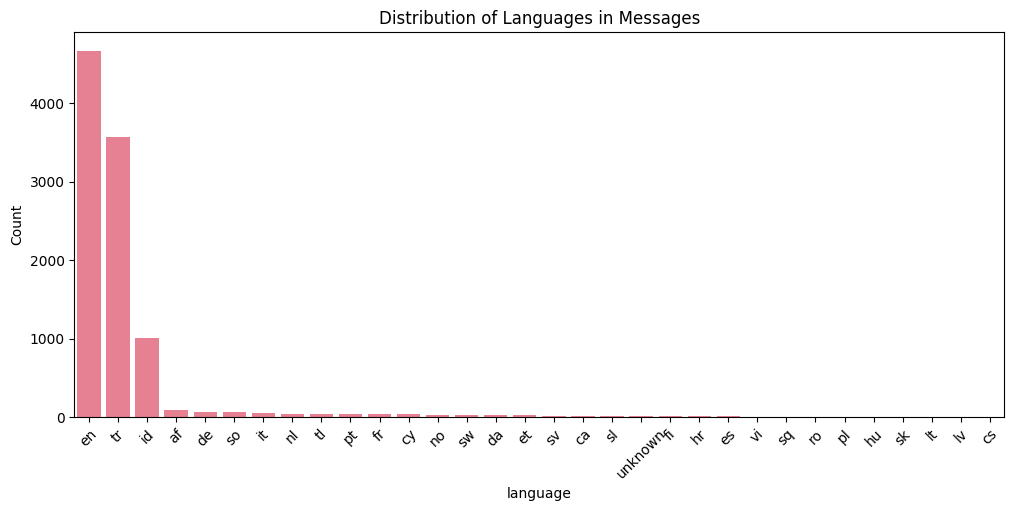


Spam Percentage by Language:


Label,0,1
language,,
af,94.25,5.75
ca,95.45,4.55
cs,100.00,0.00
cy,100.00,0.00
da,100.00,0.00
de,44.29,55.71
en,80.14,19.86
es,90.00,10.00
et,82.61,17.39


In [5]:
# PERFORM LANGUAGE DETECTION 
def detect_language(text):
    try:
        return detect(text)
    except:
        return 'unknown'

df['language'] = df['Message'].apply(detect_language)
lang_dist = df['language'].value_counts()
lang_by_class = pd.crosstab(df['language'], df['Label'], normalize='index') * 100

plt.figure(figsize=(12, 5))
sns.barplot(x=lang_dist.index, y=lang_dist.values)
plt.title('Distribution of Languages in Messages')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

print("\nSpam Percentage by Language:")
display(lang_by_class.head(10))

<Figure size 1200x600 with 0 Axes>

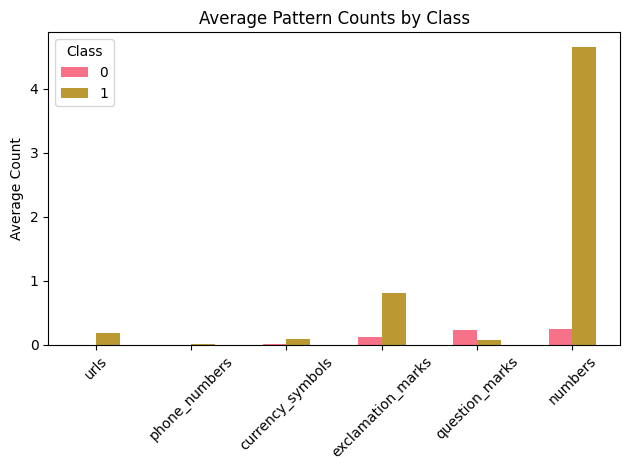


Pattern Statistics by Class:


,urls,phone_numbers,currency_symbols,exclamation_marks,question_marks,numbers
Label,,,,,,
0,0.00,0.00,0.00,0.11,0.23,0.25
1,0.18,0.01,0.09,0.81,0.08,4.65


In [6]:
# EXTRACT AND ANALYZE TEXT PATTERNS AND SPECIAL CHARACTERS
def get_pattern_counts(text):
    return {
        'urls': len(re.findall(r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', text)),
        'phone_numbers': len(re.findall(r'\b\d{10}\b|\b\d{3}[-.]?\d{3}[-.]?\d{4}\b', text)),
        'currency_symbols': len(re.findall(r'[$€£¥]', text)),
        'exclamation_marks': text.count('!'),
        'question_marks': text.count('?'),
        'numbers': len(re.findall(r'\d+', text))
    }

patterns_df = pd.DataFrame([get_pattern_counts(msg) for msg in df['Message']])
patterns_df['Label'] = df['Label']
patterns_by_class = patterns_df.groupby('Label').mean()

plt.figure(figsize=(12, 6))
patterns_by_class.T.plot(kind='bar')
plt.title('Average Pattern Counts by Class')
plt.ylabel('Average Count')
plt.xticks(rotation=45)
plt.legend(title='Class')
plt.tight_layout()
plt.show()

print("\nPattern Statistics by Class:")
display(patterns_by_class)

In [7]:
# LOAD THE DATA AND REMOVE DUPLICATES
df = pd.read_csv('datasets/sms_spam_train.csv')
df['Label'] = df['Label'].map({'spam': 1, 'ham': 0})

df = df.drop_duplicates(subset=['Message'], keep='first').reset_index(drop=True)

In [8]:
# DEFINE STOPWORDS
turkish_stopwords = set(stopwords.words('turkish'))
english_stopwords = set(stopwords.words('english'))
all_stopwords = turkish_stopwords.union(english_stopwords)
# REMOVE STOPWORDS AND SPECIFIC ARTIFACT WORDS
def preprocess_text(text):
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in all_stopwords]
    return ' '.join(filtered_words)

df['Message'] = df['Message'].apply(preprocess_text)

In [9]:
# SPLIT DATA INTO TRAINING AND TEST SETS
X_train, X_test, y_train, y_test = train_test_split(
    df['Message'], df['Label'], test_size=0.2, random_state=23, stratify=df['Label']
)

In [10]:
# DEFINE A CUSTOM TRANSFORMER FOR STATISTICAL FEATURES
class SpamFeatures(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return pd.DataFrame({
            'length': X.apply(len),
            'word_count': X.apply(lambda x: len(x.split())),
            'has_url': X.str.contains(r'http\S+|www\S+', regex=True).astype(int),
            'has_phone': X.str.contains(r'\d{10}|\d{3}[-.\s]\d{3}[-.\s]\d{4}', regex=True).astype(int),
            'punctuation_ratio': X.apply(lambda x: sum(c in '!?.,' for c in x) / (len(x) + 1))
        }).values


In [11]:
# CREATE A PIPELINE WITH TF-IDF AND STATISTICAL FEATURES
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('tfidf', TfidfVectorizer(
            max_features=1500, ngram_range=(1, 2), min_df=5, strip_accents='unicode'
        )),
        ('stats', SpamFeatures())
    ])),
    ('clf', LogisticRegression(
        C=1.0, penalty='l2', random_state=23, max_iter=200, class_weight='balanced'
    ))
])

In [22]:
# TRAIN THE MODEL
pipeline.fit(X_train, y_train)

# EVALUATE ON THE TEST SET
y_pred = pipeline.predict(X_test)

print("\nTest Set Classification Report:")
print(classification_report(y_test, y_pred))

# PERFORM CROSS-VALIDATION
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='f1')
print("\nCross-validation F1 scores:", cv_scores)
print("Average CV F1 score: {:.3f} (+/- {:.3f})".format(cv_scores.mean(), cv_scores.std() * 2))



Test Set Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      1276
           1       0.97      0.96      0.97       658

    accuracy                           0.98      1934
   macro avg       0.98      0.97      0.98      1934
weighted avg       0.98      0.98      0.98      1934


Cross-validation F1 scores: [0.96676163 0.97245964 0.96780303 0.96254682 0.97245964]
Average CV F1 score: 0.968 (+/- 0.007)



Top 10 Positive Features:


,Feature,Coefficient
1503,has_phone,4.06
1342,txt,3.46
1502,has_url,3.08
1284,tl,2.94
523,free,2.78
1257,text,2.75
1163,sms,2.69
126,50,2.34
924,mobile,2.25
1076,rek,2.23


None

Top 10 Negative Features:


,Feature,Coefficient
747,iyi,-1.40
810,kita,-1.41
614,happy,-1.43
1484,yg,-1.43
303,bir,-1.52
293,bi,-1.82
286,ben,-1.86
867,lt gt,-2.57
866,lt,-2.68
584,gt,-2.79


None


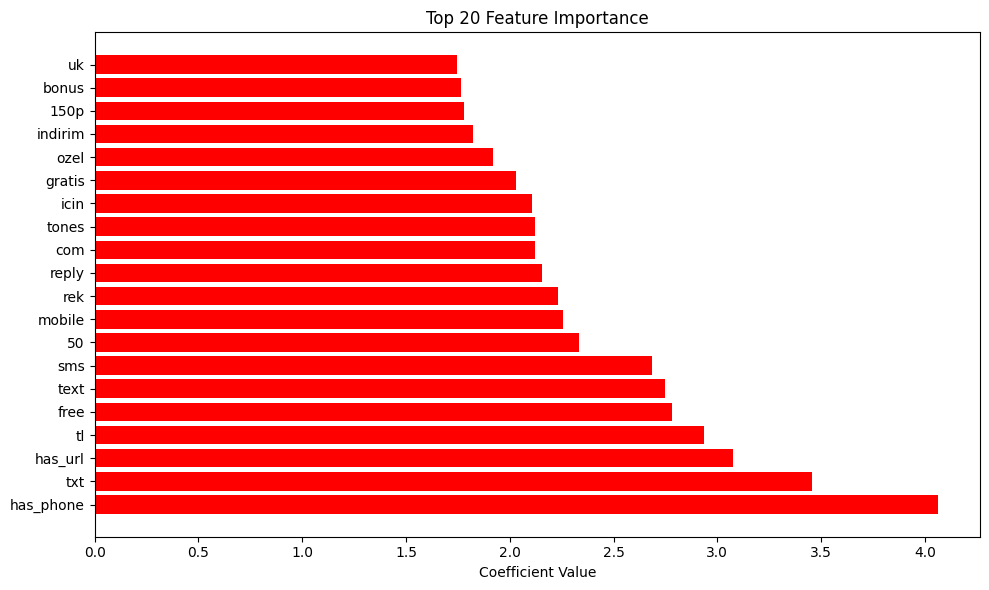

In [13]:
# EXTRACT FEATURE IMPORTANCE, OBTAIN FEATURE NAMES FROM TF-IDF AND STATISTICAL FEATURES
feature_names_tfidf = pipeline.named_steps['features'].transformer_list[0][1].get_feature_names_out()
feature_names_stats = ['length', 'word_count', 'has_url', 'has_phone', 'punctuation_ratio']
feature_names = np.concatenate([feature_names_tfidf, feature_names_stats])

# RETRIEVE LOGISTIC REGRESSION COEFFICIENTS
coefficients = pipeline.named_steps['clf'].coef_.flatten()

# COMBINE FEATURE NAMES AND COEFFICIENTS INTO A DATAFRAME
feature_importance = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# DISPLAY TOP POSITIVE AND NEGATIVE FEATURES
print("\nTop 10 Positive Features:")
print(display(feature_importance.head(10)))
print("\nTop 10 Negative Features:")
print(display(feature_importance.tail(10)))

# PLOT FEATURE IMPORTANCE
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'].iloc[:20], feature_importance['Coefficient'].iloc[:20], color='red')
plt.xlabel('Coefficient Value')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()


In [23]:
# SAVE ALL NECESSARY COMPONENTS FOR MODEL REPRODUCTION
import pickle
import os

with open('models/spam_detection_pipeline.pkl', 'wb') as f:
    pickle.dump(pipeline, f)

stopwords_dict = {
    'turkish': turkish_stopwords,
    'english': english_stopwords
}
with open('models/stopwords.pkl', 'wb') as f:
    pickle.dump(stopwords_dict, f)


pattern_dict = {
    'url_pattern': r'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\\(\\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    'phone_pattern': r'\b\d{10}\b|\b\d{3}[-.]?\d{3}[-.]?\d{4}\b',
    'currency_pattern': r'[$€£¥]',
    'number_pattern': r'\d+'
}
with open('models/regex_patterns.pkl', 'wb') as f:
    pickle.dump(pattern_dict, f)

model_metadata = {
    'train_shape': X_train.shape,
    'feature_names': feature_names,
    'feature_importance': feature_importance.to_dict(),
    'training_date': '2025-01-22',
    'model_version': '1.0',
    'accuracy': 0.98,
    'f1_score': 0.97,
    'cv_score': 0.968
}
with open('models/model_metadata.pkl', 'wb') as f:
    pickle.dump(model_metadata, f)